In [25]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
%matplotlib inline
import os
import time

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim 
from torch.utils.data import random_split
import torchvision
from torchvision import transforms, datasets
from torch.utils.data import DataLoader

In [26]:
# 做数据增强
train_transform = transforms.Compose([
    transforms.RandomCrop(32, padding=4),  #先四周填充0，在把图像随机裁剪成32*32
    transforms.RandomHorizontalFlip(),  #图像一半的概率翻转，一半的概率不翻转
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)), #R,G,B每层的归一化用到的均值和方差
])

test_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

In [27]:
# 定义训练集分批函数
def get_training_dataloader(train_transform, batch_size=128, num_workers=0, shuffle=True):

    cifar10_training = torchvision.datasets.CIFAR10(root = '.', train = True, download = True, transform = train_transform)
    cifar10_training_loader = DataLoader(
        cifar10_training, shuffle = shuffle, num_workers = num_workers, batch_size = batch_size)

    return cifar10_training_loader

# 定义测试集分批函数
def get_testing_dataloader(test_transform, batch_size=64, num_workers=0, shuffle=True):
    
    cifar10_test = torchvision.datasets.CIFAR10(root = '.', train = False, download = True, transform = test_transform)
    cifar10_test_loader = DataLoader(cifar10_test, shuffle = shuffle, num_workers = num_workers, batch_size = batch_size)

    return cifar10_test_loader

In [28]:
# 从训练集和测试集里面拿出来分批数据
trainloader = get_training_dataloader(train_transform)
testloader = get_testing_dataloader(test_transform)

Files already downloaded and verified
Files already downloaded and verified


In [29]:
# 具体化各类的名称
classes_dict = {0 : 'airplane', 1 : 'automobile', 2: 'bird', 3 : 'cat', 4 : 'deer', 5: 'dog', 6:'frog', 7 : 'horse', 8 : 'ship', 9 : 'truck'}

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

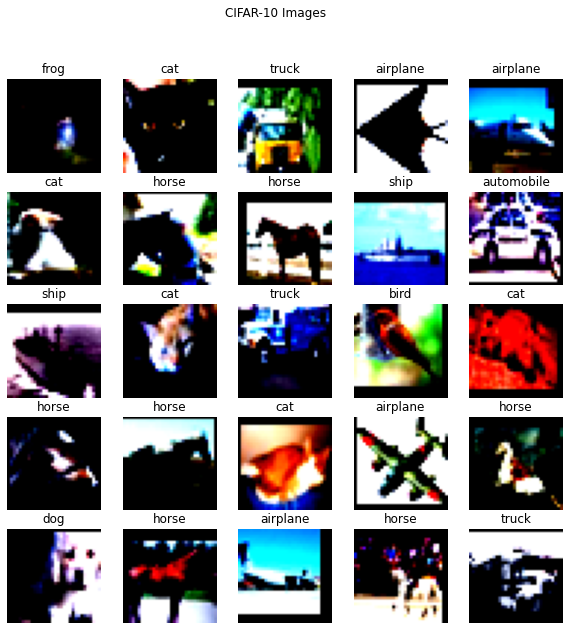

In [30]:
# 从训练集中随机的画出25个图像
fig, axs = plt.subplots(5, 5, figsize=(10,10))
    
for batch_idx, (inputs, labels) in enumerate(trainloader):
    for im in range(25):
        image = inputs[im].permute(1, 2, 0)  # permute 的作用相当于 transpose,做了转化为了输出图片
        i = im // 5
        j = im % 5
        axs[i,j].imshow(image.numpy())  # 转化为 numpy 类型输出结果
        axs[i,j].axis('off')  # 把轴关掉
        axs[i,j].set_title(classes_dict[int(labels[im].numpy())])  # 字典键的数据类型是 int 
        
    break

# 设置图的名称
plt.suptitle('CIFAR-10 Images')
plt.show()

In [31]:
# 加载模型
model = torchvision.models.densenet161(pretrained = False)  

In [32]:
# 超参数的设置
epochs = 150
learning_rate = 0.0001

device = torch.device('cuda' if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [33]:
# 定义损失函数
criterion = nn.CrossEntropyLoss()
# 设置优化器
optimizer = optim.Adam(model.parameters(),lr = learning_rate)

In [34]:
# 用来记录训练状态的 DataFrame
train_stats = pd.DataFrame(columns = ['Epoch', 'Time per epoch', 'Avg time per step', 'Train loss', 'Train accuracy', 'Train top-3 accuracy','Test loss', 'Test accuracy', 'Test top-3 accuracy']) 

In [35]:
#  训练模型
model.to(device)

running_loss = 0
for epoch in range(epochs):
    
    since = time.time()
    train_accuracy = 0
    top3_train_accuracy = 0 
    for steps,(inputs, labels) in enumerate(trainloader):
        #  把输入和标签送到 device,转化为相应的 tensor 形式
        inputs, labels = inputs.to(device), labels.to(device)     
        outs = model(inputs)
        loss = criterion(outs, labels)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        
        #  计算训练 top-1 accuracy
        outs_exp = torch.exp(outs)
        top_p, top_class = outs_exp.topk(1, dim=1)
        equals = top_class == labels.view(*top_class.shape)
        train_accuracy += torch.mean(equals.type(torch.FloatTensor)).item()
        
        # Calculate train top-3 accuracy
        np_top3_class = outs_exp.topk(3, dim=1)[1].cpu().numpy()
        target_numpy = labels.cpu().numpy()
        top3_train_accuracy += np.mean([1 if target_numpy[i] in np_top3_class[i] else 0 for i in range(0, len(target_numpy))])
        
    time_elapsed = time.time() - since
    
    # 做测试
    test_loss = 0
    test_accuracy = 0
    top3_test_accuracy = 0
    model.eval()
    with torch.no_grad():
        for inputs, labels in testloader:
            inputs, labels = inputs.to(device), labels.to(device)
            logps = model.forward(inputs)
            batch_loss = criterion(logps, labels)

            test_loss += batch_loss.item()

            # Calculate test top-1 accuracy
            ps = torch.exp(logps)
            top_p, top_class = ps.topk(1, dim=1)
            equals = top_class == labels.view(*top_class.shape)
            test_accuracy += torch.mean(equals.type(torch.FloatTensor)).item()
            
            # Calculate test top-3 accuracy
            np_top3_class = ps.topk(3, dim=1)[1].cpu().numpy()
            target_numpy = labels.cpu().numpy()
            top3_test_accuracy += np.mean([1 if target_numpy[i] in np_top3_class[i] else 0 for i in range(0, len(target_numpy))])

    print(f"Epoch {epoch+1}/{epochs}.. "
          f"Time per epoch: {time_elapsed:.4f}.. "
          f"Average time per step: {time_elapsed/len(trainloader):.4f}.. "
          f"Train loss: {running_loss/len(trainloader):.4f}.. "
          f"Train accuracy: {train_accuracy/len(trainloader):.4f}.. "
          f"Top-3 train accuracy: {top3_train_accuracy/len(trainloader):.4f}.. "
          f"Test loss: {test_loss/len(testloader):.4f}.. "
          f"Test accuracy: {test_accuracy/len(testloader):.4f}.. "
          f"Top-3 test accuracy: {top3_test_accuracy/len(testloader):.4f}")

    train_stats = train_stats.append({'Epoch': epoch, 'Time per epoch':time_elapsed, 
                                      'Avg time per step': time_elapsed/len(trainloader),
                                      'Train loss' : running_loss/len(trainloader), 
                                      'Train accuracy': train_accuracy/len(trainloader), 
                                      'Train top-3 accuracy':top3_train_accuracy/len(trainloader),
                                      'Test loss' : test_loss/len(testloader), 
                                      'Test accuracy': test_accuracy/len(testloader), 
                                      'Test top-3 accuracy':top3_test_accuracy/len(testloader)}, ignore_index=True)

    running_loss = 0  # 清掉损失
    model.train()  # 再次训练
    

Epoch 1/150.. Time per epoch: 141.9070.. Average time per step: 0.3629.. Train loss: 1.9048.. Train accuracy: 0.3764.. Top-3 train accuracy: 0.7114.. Test loss: 1.4677.. Test accuracy: 0.4627.. Top-3 test accuracy: 0.7976
Epoch 2/150.. Time per epoch: 143.8175.. Average time per step: 0.3678.. Train loss: 1.4232.. Train accuracy: 0.4810.. Top-3 train accuracy: 0.8088.. Test loss: 1.3448.. Test accuracy: 0.5082.. Top-3 test accuracy: 0.8233
Epoch 3/150.. Time per epoch: 144.8455.. Average time per step: 0.3704.. Train loss: 1.2917.. Train accuracy: 0.5341.. Top-3 train accuracy: 0.8421.. Test loss: 1.2253.. Test accuracy: 0.5522.. Top-3 test accuracy: 0.8519
Epoch 4/150.. Time per epoch: 148.8098.. Average time per step: 0.3806.. Train loss: 1.1991.. Train accuracy: 0.5695.. Top-3 train accuracy: 0.8613.. Test loss: 1.1449.. Test accuracy: 0.5909.. Top-3 test accuracy: 0.8764
Epoch 5/150.. Time per epoch: 148.1577.. Average time per step: 0.3789.. Train loss: 1.1257.. Train accuracy: 0.

KeyboardInterrupt: 

In [36]:
# 保存模型参数
torch.save(model,'cifar-10 densenet161.pt')  # 模型保存为 pkl 和 pt 均可
print('cifar10-densenet161.pt saved !')

train_stats.to_csv('train_log_DenseNet121.csv')
print('train_log_DenseNet161.csv saved !')

cifar10-densenet161.pt saved !
train_log_DenseNet161.csv saved !


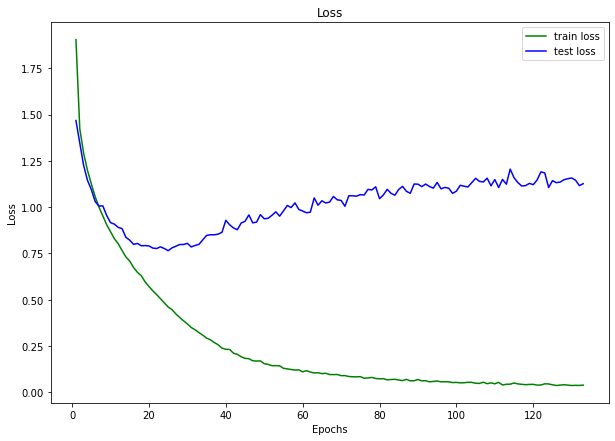

In [37]:
# 绘制损失函数变换曲线
fig = plt.figure(figsize=(10,7))
ax = plt.axes()

plt.title("Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")

x = range(1, len(train_stats['Train loss'].values) + 1)
ax.plot(x, train_stats['Train loss'].values, '-g', label='train loss')
ax.plot(x, train_stats['Test loss'].values, '-b', label='test loss')

plt.legend()
plt.savefig('loss_curve.png')

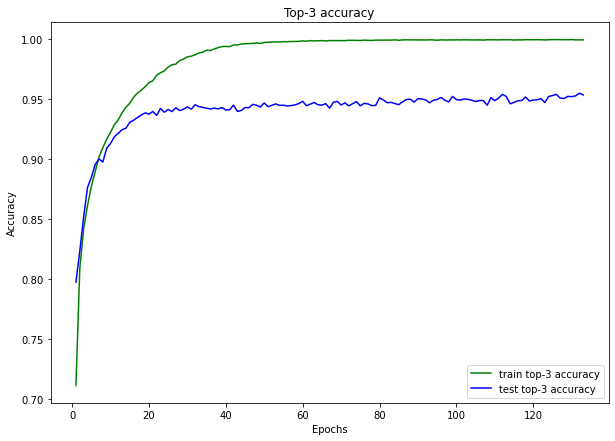

In [38]:
# 绘制预测 top-3精确度变化曲线
fig = plt.figure(figsize=(10,7))
ax = plt.axes()

plt.title("Top-3 accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")

x = range(1, len(train_stats['Train top-3 accuracy'].values) + 1)
ax.plot(x, train_stats['Train top-3 accuracy'].values, '-g', label='train top-3 accuracy')
ax.plot(x, train_stats['Test top-3 accuracy'].values, '-b', label='test top-3 accuracy')

plt.legend(loc = 'best')
plt.savefig('Top-3 accuracy curve.png')

In [39]:
# 最后的准确率
# 模型加载
model = torch.load('cifar-10 densenet161.pt')
# 测试
model.eval()  # 因为这里面是测试阶段，所以要把模型里面的参数固定住，不再更新
correct,total = 0,0 
for (inputs,labels) in testloader:  # 因为 test_loader 的数据量不大，所以不分批
    inputs,labels = inputs.to(device),labels.to(device)
    # 前向传播
    outputs = model(inputs)
    _,predicted = torch.max(outputs,1)  # outputs 在这里输出是tensor的格式，这里的 1 表示行这一维度，这里面可以使用argmax
    total = total + labels.size(0)
    correct = correct + (predicted == labels).sum().item()
    
# 输出测试集的准确率
print('测试图像10000 张的准确率：{:.4f}%'.format(100.0 * correct/total))

测试图像10000 张的准确率：79.6700%
